see "Efficient excitation of a two-level atom by a single photon in a propagating mode". The equation numbers referenced below refer to this paper unless otherwise noted.

This notebook does not correctly map the results from Heisenberg-Langevin into the Lindblad density matrix picture, but I have done this in my similarly named Mathematica notebook.

In [1]:
from qutip import *
from numpy import *
from numpy.random import normal
import numpy.linalg as la
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

### Two-level atom interacting with a propagating single photon mode

### Heisenberg equation
A matrix M is obtained from taking matrix elements of the atomic operators sigma_z, sigma_+ and sigma_- with the initial state vector s (which includes the atom, incident field, and environment field).

#### perfect mode matching of pulse to dipole pattern
This assumption implies that the impinging pulse spans the entire solid angle
such that all of the atomic decay is into the pulse mode, i.e. the the pulse mode is a spherical wave travelling in towards the origin (this can be seen in Eq. 15). We will walk
back this assumption in the next section.

In [2]:
"""
See Eqs. 18, 21, 23, and section IV of 
Wang. et. al., "Efficient excitation of a two-level atom by a single photon 
in a propagating mode"
"""

# for explicit Gamma_p/Gamma relation, see eqs. 15, 16

Gamma = 1 # the total emission into all modes. set to 1.
Gamma_p = Gamma # assumption of perfect dipole pattern mode matching

solns = []

Omega0 = 1.5*Gamma
Omega_list = [0.1*Omega0, Omega0, 10*Omega0]
g_list = []

for i,Omega in enumerate(Omega_list):

    # see Table I
    g = lambda t: sqrt(Gamma_p)*(Omega**2/(2*pi))**(1/4)*exp(-(Omega*t)**2/4)
    g_list.append(g)
    
    def M(t):
        mat = array([[-Gamma, -2*g(t), -2*g(t)],
                     [0, -Gamma/2, 0],
                     [0, 0, -Gamma/2]])
        return mat
    
    def b(t):
        return array([-Gamma, -g(t), -g(t)])
    
    # start in |g>|1p>|0e>, where p,e are incident and environment modes
    # s0 = array([0.0, 1.0, 0.0], complex)
    s0 = array([1.0, 0.0, 0.0], complex)
    
    numsteps = 1000

    # need to start far enough back in time that the pulse amplitude
    # at the atom is ~ 0
    tmin = -100
    tmax = 10
    tpts = linspace(tmin,tmax,numsteps)
    
    def ds(t, s):
        sdot = (M(t).dot(s)).transpose() + b(t)
        # print(sdot.
        return sdot
    
    soln = solve_ivp(ds,[tmin,tmax], s0, t_eval=tpts, vectorized=True)
    solns.append(soln)
    print("soln", i, "done")

soln 0 done
soln 1 done
soln 2 done


In [4]:
ds(0,[1,1,1])

array([-11.78499603,  -2.94624901,  -2.94624901])

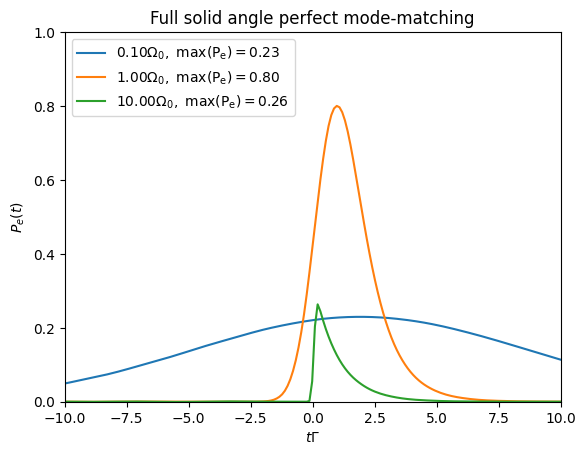

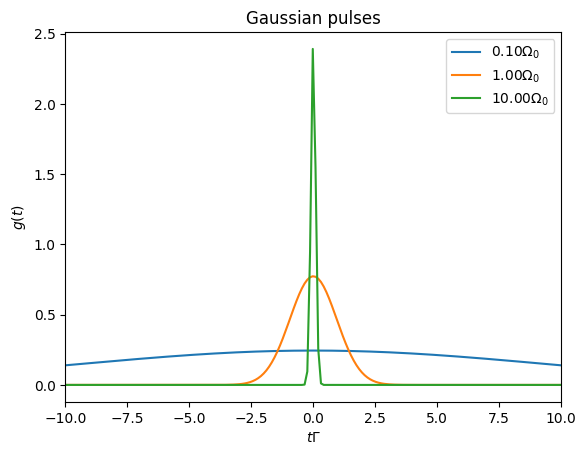

In [3]:
for soln,Omega in zip(solns,Omega_list):
    Pe = 0.5*(real(soln.y[0])+1)
    maxPe = max(Pe[soln.t > -10])
    plt.plot(soln.t*Gamma,Pe,label=rf'{Omega/Omega0:.2f}$\Omega_0,~\rm max(P_e)=${maxPe:.2f}')
plt.ylabel(r"$P_e(t)$")
plt.xlabel(r"$t\Gamma$")
plt.title("Full solid angle perfect mode-matching")
plt.xlim((-10,10))
plt.ylim((0,1))
plt.legend()
plt.show()

for gfunc,Omega in zip(g_list,Omega_list):
    plt.plot(soln.t*Gamma,gfunc(soln.t),label=rf'{Omega/Omega0:.2f}$\Omega_0$')
plt.ylabel(r"$g(t)$")
plt.xlabel(r"$t\Gamma$")
plt.title("Gaussian pulses")
plt.xlim((-10,10))
# plt.ylim((0,1))
plt.legend()
plt.show()

#### imperfect mode matching of pulse to dipole pattern
The imperfect mode matching is completely encapsulated by integrating the pulse mode over the solid angle, as done in equation 15. Because the result is that $\Gamma_p \propto \Gamma$ where the latter is the free space emission rate into the full solid angle, for now we can express the former as a multiple of the latter.

In [335]:
"""
See Eqs. 18, 21, 23, and section IV of 
Wang. et. al., "Efficient excitation of a two-level atom by a single photon 
in a propagating mode"
"""

# for explicit Gamma_p/Gamma relation, see eqs. 15, 16

Gamma = 1 # the total emission into all modes. set to 1.
# 0.94 is 134deg parabolic mirror from Leuchs group
Gamma_p = 0.94 # the prefactor is just the mode overlap. 
Gamma_p = 0.5 # the prefactor is just the mode overlap. 
solns = []

Omega0 = 1.5*Gamma
Omega_list = [0.1*Omega0, Omega0, 10*Omega0]

for i,Omega in enumerate(Omega_list):

    # see Table I
    g = lambda t: sqrt(Gamma_p)*(Omega**2/(2*pi))**(1/4)*exp(-(Omega*t)**2/4)
    
    def M(t):
        mat = array([[-Gamma, -2*g(t), -2*g(t)],
                     [0, -Gamma/2, 0],
                     [0, 0, -Gamma/2]])
        return mat
    
    def b(t):
        return array([-Gamma, -g(t), -g(t)])
    
    # start in |g>|1p>|0e>, where p,e are incident and environment modes
    s0 = array([0.0, 1.0, 0.0], complex)
    
    numsteps = 1000

    # need to start far enough back in time that the pulse amplitude
    # at the atom is ~ 0
    tmin = -100
    tmax = 10
    tpts = linspace(tmin,tmax,numsteps)
    
    def ds(t, s):
        sdot = (M(t).dot(s)).transpose() + b(t)
        # print(sdot.
        return sdot
    
    soln = solve_ivp(ds,[tmin,tmax], s0, t_eval=tpts, vectorized=True)
    solns.append(soln)
    print("soln", i, "done")

soln 0 done
soln 1 done
soln 2 done


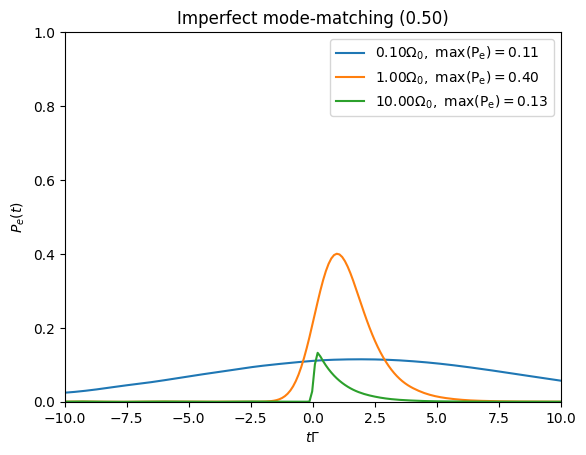

In [338]:
for soln,Omega in zip(solns,Omega_list):
    Pe = 0.5*(real(soln.y[0])+1)
    maxPe = max(Pe[soln.t > -10])
    plt.plot(soln.t*Gamma,Pe,label=rf'{Omega/Omega0:.2f}$\Omega_0,~\rm max(P_e)=${maxPe:.2f}')
plt.ylabel(r"$P_e(t)$")
plt.xlabel(r"$t\Gamma$")
plt.title(f"Imperfect mode-matching ({Gamma_p/Gamma:.2f})")
plt.xlim((-10,10))
plt.ylim((0,1))
plt.legend()

### Schrodinger equation
The equation solved here is from "time-reveral-symmetric single photon wave-packets for free space quantum comm." by the Leuchs group, PRL 2013. See my handwritten notes in OneNote.

#### Two-level case
This is a simplified system compared to the one in the Leuchs group paper. Rather than a four level system and classical driving fields, I only consider the photon packet incident on a two level atom (states g2 and r in the paper).

In [385]:
"""
See Eqs. 18, 21, 23, and section IV of 
Wang. et. al., "Efficient excitation of a two-level atom by a single photon 
in a propagating mode"
"""

# for explicit Gamma_p/Gamma relation, see eqs. 15, 16

Gamma = 1 # the total emission into all modes. set to 1.

# start in |g>
psi0 = array([1,0], complex)

solns = []

Omega0 = 1.5*Gamma
Omega_list = [0.1*Omega0, Omega0, 10*Omega0]

for i,Omega in enumerate(Omega_list):

    g = lambda t: sqrt(Gamma)*(Omega**2/(2*pi))**(1/4)*exp(-(Omega*t)**2/4)
    H = lambda t: array([[0, -g(t)],[-g(t), -1j*Gamma/2]])
    
    def dpsi(t, psi):
        LHS = -1j*dot(H(t),psi)
        return LHS
    
    numsteps = 1000

    # need to start far enough back in time that the pulse amplitude
    # at the atom is ~ 0
    tmin = -100
    tmax = 10
    tpts = linspace(tmin,tmax,numsteps)
    
    soln = solve_ivp(dpsi, [tmin,tmax], psi0, t_eval=tpts, vectorized=True)
    solns.append(soln)
    print("soln", i, "done")

soln 0 done
soln 1 done
soln 2 done


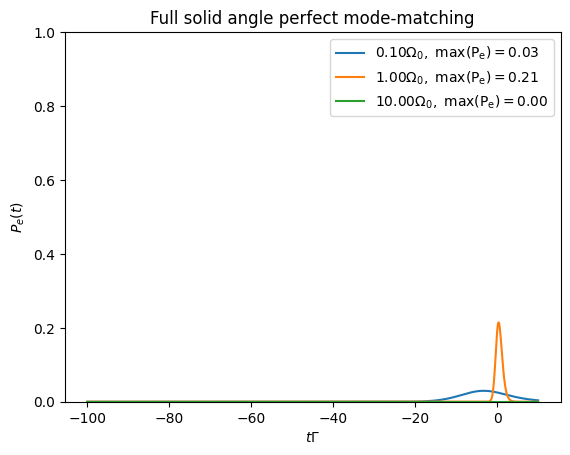

In [386]:
for soln,Omega in zip(solns,Omega_list):
    Pe = abs(soln.y[1])**2
    maxPe = max(Pe[soln.t > -10])
    plt.plot(soln.t*Gamma,Pe,label=rf'{Omega/Omega0:.2f}$\Omega_0,~\rm max(P_e)=${maxPe:.2f}')
plt.ylabel(r"$P_e(t)$")
plt.xlabel(r"$t\Gamma$")
plt.title("Full solid angle perfect mode-matching")
# plt.xlim((-10,10))
plt.ylim((0,1))
plt.legend()

### Louiville/Linblad equation

### scipy

In [428]:
"""
See Eqs. 18, 21, 23, and section IV of 
Wang. et. al., "Efficient excitation of a two-level atom by a single photon 
in a propagating mode"
"""

# for explicit Gamma_p/Gamma relation, see eqs. 15, 16

Gamma = 1 # the total emission into all modes. set to 1.

# start in |g>
rho0 = array([1,0,0], complex) # rho_g, rho_e, rho_eg

solns = []

Omega0 = 1.5*Gamma
Omega_list = [0.1*Omega0, Omega0, 10*Omega0]

for i,Omega in enumerate(Omega_list):

    g = lambda t: sqrt(Gamma)*(Omega**2/(2*pi))**(1/4)*exp(-(Omega*t)**2/4)
    
    def drho(t,rho0):
        """ Returns RHS of optical bloch eqs for current values at time t"""
        rgg,ree,reg = rho0
        
        # time derivatives of density op elements
        curl = 1j/2*(g(t)*conj(reg)-g(t)*reg) 
        drgg = ree*Gamma - curl 
        dree = -ree*Gamma + curl
        dreg = (-Gamma/2)*reg+1j*g(t)/2*(rgg-ree) # = cc(drge)
        
        return array([drgg,dree,dreg])
    
    numsteps = 1000

    # need to start far enough back in time that the pulse amplitude
    # at the atom is ~ 0
    tmin = -100
    tmax = 10
    tpts = linspace(tmin,tmax,numsteps)
    
    soln = solve_ivp(drho, [tmin,tmax], rho0, t_eval=tpts, vectorized=True)
    solns.append(soln)
    print("soln", i, "done")

soln 0 done
soln 1 done
soln 2 done


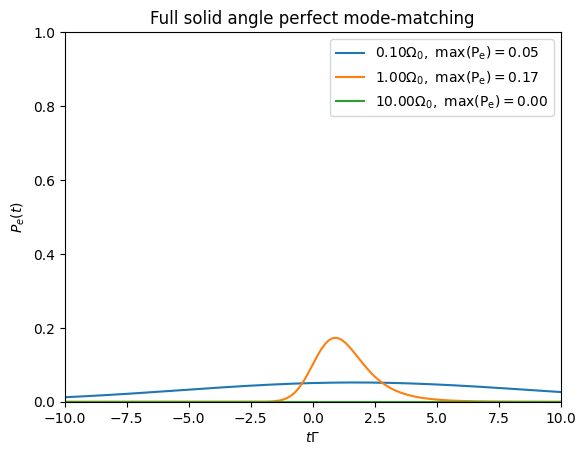

In [429]:
for soln,Omega in zip(solns,Omega_list):
    Pe = abs(soln.y[1])
    maxPe = max(Pe[soln.t > -10])
    plt.plot(soln.t*Gamma,Pe,label=rf'{Omega/Omega0:.2f}$\Omega_0,~\rm max(P_e)=${maxPe:.2f}')
plt.ylabel(r"$P_e(t)$")
plt.xlabel(r"$t\Gamma$")
plt.title("Full solid angle perfect mode-matching")
plt.xlim((-10,10))
plt.ylim((0,1))
plt.legend()

### QuTip
Solve the master equation with QuTip. See "vacuum Rabi oscillations.ipynb"

This fails to produce correct excitation probabilities. It might not be valid to simply plop the interaction Hamiltonian into the qutip sim, or I made an error. It might be that I need to actually transform the Heisenberg operator equations into a Linblad form.

In [446]:
# intial state

N = 2 # number of Fock states (dimension of photon number basis)
psi0 = tensor(basis(N, 0), basis(2, 0)) # no photon, atom in |g>: nothing should happen
psi0 = tensor(basis(N, 1), basis(2, 0)) # one photon , atom in |g>

# collapse operators
a = tensor(destroy(N), qeye(2))
Imat = tensor(qeye(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())
sz = tensor(qeye(N), sigmaz())

Gamma = 1 # the total emission into all modes. set to 1.
Gamma_p = Gamma # assumption of perfect dipole pattern mode matching
Omega0 = 1.5*Gamma*2
Omega = Omega0

g_func = lambda t: sqrt(Gamma_p)*(Omega**2/(2*pi))**(1/4)*exp(-(Omega*t)**2/4)
g = coefficient(g_func)

# H0 = 0 #wc * a.dag() * a + wa / 2 * sz
H0 = 0 #(sm * sm.dag())*(-1j*Gamma/2) # 
HI = g * (a.dag() * sm + a * sm.dag()) # RWA interaction Hamiltonian
H = HI + H0

c_op_list = [
    # g_sqrt * a, # photon annihilation
    sqrt(Gamma/2) * sm, # atom annihilation
    sqrt(Gamma) * sz, # coherence decay,
    sqrt(Gamma) * Imat,
    sqrt(Gamma/2) * a.dag() # photon creation (from atom emission back into the pulse mode)
]

tmin = -100
tmax = 10
tpts = linspace(tmin,tmax,numsteps)

output = mesolve(H, psi0, tpts, c_op_list, [
    a.dag() * a, sm.dag() * sm])

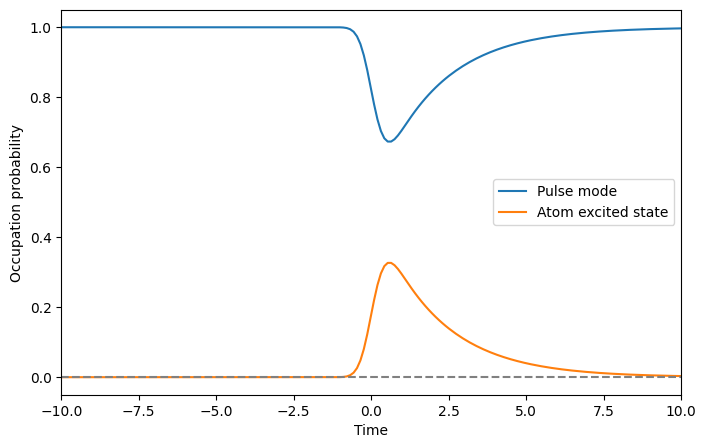

In [447]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tpts, output.expect[0], label="Pulse mode")
ax.plot(tpts, output.expect[1], label="Atom excited state")
ax.axhline(0, ls='--', color='gray')
ax.set_xlim((-10,10))
# ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
plt.show()

In [463]:
dot(sigmam() * array([1,0]))

TypeError: operand 'Qobj' does not support ufuncs (__array_ufunc__=None)

In [454]:
(0.5)*(sigmax() - 1j*sigmay())

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [455]:
destroy(2)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [362]:
# intial state

N = 2 # number of Fock states (dimension of photon number basis)
psi0 = tensor(basis(N, 1), basis(2, 0))

# collapse operators
a = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2).dag())
sz = tensor(qeye(N), sigmaz())

Gamma = 1 # the total emission into all modes. set to 1.
Gamma_p = Gamma # assumption of perfect dipole pattern mode matching
solns = []

Omega0 = 1.5*Gamma
Omega_list = [0.1*Omega0, Omega0, 10*Omega0]

for i,Omega in enumerate(Omega_list):

    g_func = lambda t: 2*sqrt(Gamma_p)*(Omega**2/(2*pi))**(1/4)*exp(-(Omega*t)**2/4)
    g = coefficient(g_func)
    
    # H0 = 0 #wc * a.dag() * a + wa / 2 * sz
    H0 = 0 #(sm * sm.dag())*(-1j*Gamma/2) # 
    HI = g * (a.dag() * sm + a * sm.dag()) # RWA interaction Hamiltonian
    H = HI + H0
    
    c_op_list = [
        # g_sqrt * a, # photon annihilation
        sqrt(Gamma) * sm, # atom annihilation
        sqrt(Gamma) * a.dag() # photon creation (from atom emission back into the pulse mode)
    ]
    
    tmin = -100
    tmax = 10
    tpts = linspace(tmin,tmax,numsteps)
    
    output = mesolve(H, psi0, tpts, c_op_list, [
        a.dag() * a, sm.dag() * sm])
    solns.append(output.expect[1])
    print("soln", i, "done")

soln 0 done
soln 1 done
soln 2 done


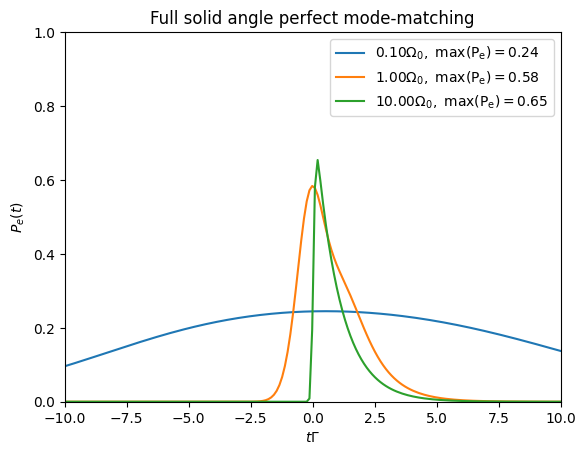

In [363]:
for soln,Omega in zip(solns,Omega_list):
    Pe = soln
    maxPe = max(Pe[tpts > -10])
    plt.plot(tpts*Gamma,Pe,label=rf'{Omega/Omega0:.2f}$\Omega_0,~\rm max(P_e)=${maxPe:.2f}')
plt.ylabel(r"$P_e(t)$")
plt.xlabel(r"$t\Gamma$")
plt.title("Full solid angle perfect mode-matching")
plt.xlim((-10,10))
plt.ylim((0,1))
plt.legend()

In [228]:
array([0.23, 0.8, 0.26])/array([0.07, 0.23, 0.17])

array([3.28571429, 3.47826087, 1.52941176])

In [231]:
array([0.23, 0.8, 0.26])**2/array([0.07, 0.23, 0.17])

array([0.75571429, 2.7826087 , 0.39764706])